In [73]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt 

# Envoltória Convexa
Computação da Envolória Convexa utilizando a Varredura de Graham

In [74]:
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0  # colinear
    return 1 if val > 0 else 2  # horário (1) ou anti-horário (2)

def polar_angle(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return np.arctan2(y_span, x_span)

def distance(p0, p1):
    return (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2

def graham_scan(points):
    n = len(points)

    # ponto com a coordenada y mais baixa
    ymin = min(points, key=lambda x: x[1])
    min_index = points.index(ymin)
    points[0], points[min_index] = points[min_index], points[0]  # troca o ponto inicial com o primeiro ponto

    # ordena os pontos por ângulo polar e depois por distância
    pivot = points[0]
    sorted_points = sorted(points[1:], key=lambda x: (polar_angle(pivot, x), -distance(pivot, x))) # ordena por ângulo polar e depois por distância em caso de empate

    # inicializa a pilha
    stack = [pivot, sorted_points[0], sorted_points[1]]

    # processamento
    for point in sorted_points[2:]:
        # enquanto houver mudança de direção no sentido horário, remove o último ponto da pilha
        while len(stack) > 1 and orientation(stack[-2], stack[-1], point) !=2:
            stack.pop()
        stack.append(point)
    
    return stack


# Testes Iniciais - Iris

In [75]:
# Função para verificar se dois segmentos se interceptam
def doIntersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    return False

Verificar se as classes são linearmente separáveis

In [76]:
from sklearn.datasets import load_iris

# Carregar o dataset Iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target_names[iris.target]

# Filtrar para obter apenas duas classes
filtered_df = df[df['species'].isin(['setosa', 'versicolor'])]

# Separar os pontos das duas classes
class1_points = filtered_df[filtered_df['species'] == 'setosa'][df.columns[:2]].values
class2_points = filtered_df[filtered_df['species'] == 'versicolor'][df.columns[:2]].values

# Calcular as envoltórias convexas
hull_class1 = graham_scan(class1_points.tolist())
hull_class2 = graham_scan(class2_points.tolist())

# Verificar se as envoltórias convexas se interceptam
are_separable = True
for i in range(len(hull_class1) - 1):
    for j in range(len(hull_class2) - 1):
        if doIntersect(hull_class1[i], hull_class1[i + 1], hull_class2[j], hull_class2[j + 1]):
            are_separable = False
            break

# Imprimir o resultado
if are_separable:
    print("As classes são separáveis linearmente.")
else:
    print("As classes não são separáveis linearmente.")

As classes são separáveis linearmente.


# Redução de dimensionalidade

In [77]:
iris2 = load_iris()
df2 = pd.DataFrame(iris2.data, columns=iris2.feature_names)
df2.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [78]:
iris2 = load_iris()
#selecting only setosa and versicolor

df2 = pd.DataFrame(iris2.data, columns=iris2.feature_names)
df2['species'] = iris2.target_names[iris2.target]
df2.head()

#drop virginica rows
df2 = df2[df2['species'] != 'virginica']
df2['species'].value_counts()
#drop species column
df2 = df2.drop(['species'], axis=1)

PCA para redução de dimensionalidade

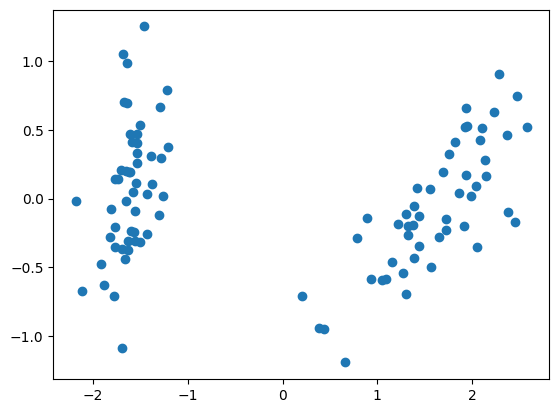

In [79]:
#use pca to reduce the dimensionality of the data to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df2)
df2 = pca.transform(df2)

# create two new columns to store the x and y axis values
df2 = pd.DataFrame(df2)
df2.columns = ['x', 'y']
df2.head()

#plot the data
plt.scatter(df2['x'], df2['y'])
plt.show()

# Ponto mais próximo

Calcular o ponto de uma envoltória mais próximo de outra envoltória e em seguida plotar o segmento de reta entre os dois pontos

A menor distância entre as envoltórias convexas é: 0.24327007187250252


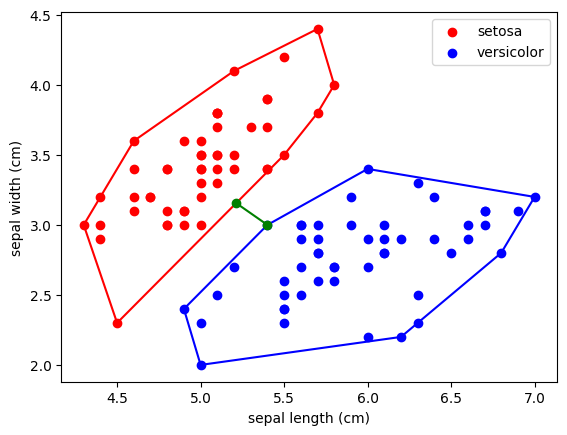

In [80]:
#calcular os dois pontos mais proximos entre as duas envoltórias
# Função para calcular a distância euclidiana entre dois pontos
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Função para calcular a distância do ponto até o segmento de linha
def point_to_segment_distance(p, a, b):
    # Vetorizando os pontos
    p = np.array(p)
    a = np.array(a)
    b = np.array(b)
    
    # Calculando os vetores
    ap = p - a
    ab = b - a
    
    # Calculando o produto escalar
    dot_product = np.dot(ap, ab) / np.dot(ab, ab)
    
    # Evitando que o ponto de projeção saia do segmento de linha
    dot_product = np.clip(dot_product, 0, 1)
    
    # Calculando o ponto de projeção no segmento de linha
    projection = a + dot_product * ab
    
    # Calculando a distância entre o ponto e o ponto de projeção
    return euclidean_distance(p, projection), projection

# Calcular a menor distância entre as envoltórias convexas
min_distance = float('inf')
closest_pair = (None, None)

# Distância entre pontos
for p1 in hull_class1:
    for p2 in hull_class2:
        distance = euclidean_distance(p1, p2)
        if distance < min_distance:
            min_distance = distance
            closest_pair = (p1, p2)

# Distância ponto-segmento
for i in range(len(hull_class1) - 1):
    for p2 in hull_class2:
        distance, projection = point_to_segment_distance(p2, hull_class1[i], hull_class1[i+1])
        if distance < min_distance:
            min_distance = distance
            closest_pair = (projection, p2)

for i in range(len(hull_class2) - 1):
    for p1 in hull_class1:
        distance, projection = point_to_segment_distance(p1, hull_class2[i], hull_class2[i+1])
        if distance < min_distance:
            min_distance = distance
            closest_pair = (p1, projection)

print("A menor distância entre as envoltórias convexas é:", min_distance)

# Plotar os pontos e as envoltórias convexas
plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label='setosa')
plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label='versicolor')

hull_class1 = np.vstack((hull_class1, hull_class1[0]))
hull_class2 = np.vstack((hull_class2, hull_class2[0]))

plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')

# Plotar a menor distância
plt.plot(*closest_pair[0], 'go')  # ponto ou projeção na envoltória 1
plt.plot(*closest_pair[1], 'go')  # ponto ou projeção na envoltória 2
plt.plot([closest_pair[0][0], closest_pair[1][0]], 
         [closest_pair[0][1], closest_pair[1][1]], 'g-')  # linha representando a menor distância

plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.legend()
plt.show()

# Linha perpendicular de separação

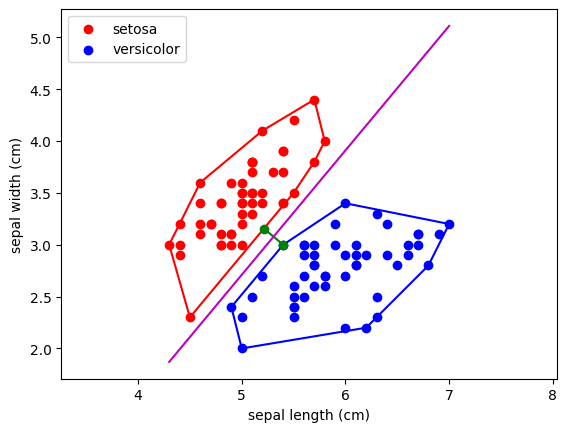

In [81]:
def compute_perpendicular_line(p1, p2):
    # Calculate the slope of the line formed by the two closest points
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
        # Calculate the slope of the perpendicular line
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = 0  # horizontal line
    else:
        perp_slope = float('inf')  # vertical line

    # Calculate the midpoint of the segment
    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    # Calculate the y-intercept of the perpendicular line
    y_intercept = midpoint[1] - perp_slope * midpoint[0]

    return perp_slope, y_intercept, midpoint

# Extract the slope, y-intercept, and midpoint of the perpendicular line
perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

# Plot the points and convex hulls
plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label='setosa')
plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label='versicolor')

plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')

# Plot the shortest distance
plt.plot(*closest_pair[0], 'go')
plt.plot(*closest_pair[1], 'go')
plt.plot([closest_pair[0][0], closest_pair[1][0]], 
         [closest_pair[0][1], closest_pair[1][1]], 'g-')

# Plot the perpendicular line
if abs(perp_slope) != float('inf'):
    x = np.linspace(min(class1_points[:, 0].min(), class2_points[:, 0].min()), 
                    max(class1_points[:, 0].max(), class2_points[:, 0].max()), 400)
    y = perp_slope * x + y_intercept
    plt.plot(x, y, 'm-')
else:
    plt.axvline(x=midpoint[0], color='m', linestyle='-')

plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.legend()
plt.axis('equal')
plt.show()


## Verificar à qual classe um novo ponto pertence

In [82]:
classes = [ 'setosa', 'versicolor']

In [83]:
import numpy as np
import matplotlib.pyplot as plt

def perpendicular_line_equation(closest_pair):
    
    #Calcula a equação da reta perpendicular que passa pelo ponto médio

    p1, p2 = closest_pair

    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]
    
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
        perp_slope = -1 / slope if slope != 0 else float('inf')
    else:
        perp_slope = 0

    A = -perp_slope
    B = 1
    C = perp_slope * midpoint[0] - midpoint[1]

    line_coeficients = [A, B, C]
    return line_coeficients
    

def class_position(classes, closest_pair, line_coeficients):

    A, B, C = line_coeficients

    value = A * closest_pair[0][0] + B * closest_pair[0][1] + C
    if value > 0:
        class_above = classes[0]
        class_below = classes[1]
        return class_above, class_below
    elif value < 0:
        class_above = classes[1]
        class_below = classes[0]
        return class_above, class_below


def determine_class(class_above, class_below, point, line_coeficients):

    A, B, C = line_coeficients

    #Determina a qual classe o ponto pertence

    value = A * point[0] + B * point[1] + C
    
    if value > 0:
        return class_above
    elif value < 0:
        return class_below
    else:
        return "on the line"
   


def plot_data(class1_points, class2_points, hull_class1, hull_class2, closest_pair, test_point, line_coeficients):
    A, B, C = line_coeficients

    #Plota o gráfico
    plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label='setosa')
    plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label='versicolor')

    plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
    plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')

    # Plot the shortest distance
    plt.plot(*closest_pair[0], 'g-')
    plt.plot(*closest_pair[1], 'g-')
    plt.plot([closest_pair[0][0], closest_pair[1][0]], 
            [closest_pair[0][1], closest_pair[1][1]], 'g-')

    if abs(A) != float('inf'):
        x = np.linspace(min(class1_points[:, 0].min(), class2_points[:, 0].min()), 
                        max(class1_points[:, 0].max(), class2_points[:, 0].max()), 400)
        y = (-A * x - C) / B
        plt.plot(x, y, '-m')
    else:
        plt.axvline(x=midpoint[0],  color='magenta', linestyle='-')

    plt.plot(test_point[0], test_point[1], 'o', color='magenta', label='Test Point')

    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.axis('equal')
    plt.show()



The test point belongs to the class: setosa


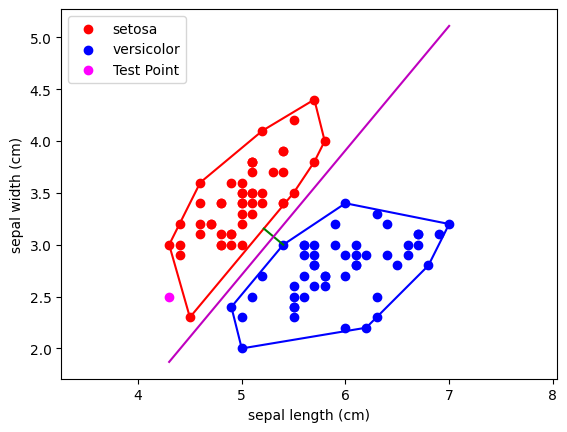

In [84]:
# Exemplo de uso:
line_coeficients = perpendicular_line_equation(closest_pair)
test_point = [4.3, 2.5]
class_above, class_below = class_position(classes, closest_pair, line_coeficients)
species = determine_class(class_above, class_below, test_point, line_coeficients)
print(f"The test point belongs to the class: {species}")
plot_data(class1_points, class2_points, hull_class1, hull_class2, closest_pair, test_point, line_coeficients)



In [85]:
#testset

line_coeficients = perpendicular_line_equation(closest_pair)
class_above, class_below = class_position(classes, closest_pair, line_coeficients)

def predict_classes(df, line_coeficients, class_above, class_below):
    
   #Aplica a função determine_class para cada ponto do dataset e armazena o resultado na coluna 'Predicted Class'
   df['Predicted Class'] = df.apply(lambda row: determine_class([row['x'], row['y']], line_coeficients, class_above, class_below), axis=1)
   return df